## Periodic boundary conditions

Even with cut-offs, it is still not possible to simulate a *realistic* system, as this would require many more atoms than are possible on current computers.
An example of a very large molecular dynamics simulation is ~3 million atoms [[1](#references)]. 
However, this is still only 1.8×10<sup>-16</sup> moles, which is **not close** to a realistic amount of substance.

The use of **periodic boundary conditions** (PBCs) creates an infinite pseudo-crystal of the simulation cell, arranged in a lattice. 
This allows for more realistic simulations as the system is able to interact through the cell walls with the adjacent cell. 
Figure 1 shows a pictorial example of a PBC. 

<center>
    <br>
    <img src="../images/pbc.png" width="300px"><br>
    <i>Figure 1. A two-dimensional example of a periodic cell.</i>
    <br>
</center>

When a particle reaches the cell wall it moves into the adjecent cell, and since all the cells are identical, it appears on the other side. 
The code below modifies the `update_pos` and `get_acceleration` functions defined previously to account for the periodic boundary condition.

In [14]:
import numpy as np
import matplotlib.pyplot as plt
mass_of_argon = 39.948 # amu

def update_pos(x, v, a, dt, box_length):
    """
    Update the particle positions accounting for the 
    periodic boundary condition.
    
    Parameters
    ----------
    x: ndarray of floats
        The positions of the particles in a single dimension
    v: ndarray of floats
        The velocities of the particles in a single dimension
    a: ndarray of floats
        The accelerations of the particles in a single dimension
    dt: float
        The timestep length
    box_length: float 
        The size of the periodic cell
    
    Returns
    -------
    ndarray of floats:
        New positions of the particles in a single dimension
    """
    new_pos = x + v * dt + 0.5 * a * dt * dt
    #print(new_pos)
    new_pos = new_pos % box_length
    #print(new_pos)
    return new_pos

def lj_force(r, epsilon, sigma):
    """
    Implementation of the Lennard-Jones potential 
    to calculate the force of the interaction.
    
    Parameters
    ----------
    r: float
        Distance between two particles (Å)
    epsilon: float 
        Potential energy at the equilibrium bond 
        length (eV)
    sigma: float 
        Distance at which the potential energy is 
        zero (Å)
    
    Returns
    -------
    float
        Force of the van der Waals interaction (eV/Å)
    """
    return 48 * epsilon * np.power(
        sigma / r, 13) - 24 * epsilon * np.power(
        sigma / r, 7)

def get_accelerations(positions, box_length, cutoff):
    """
    Calculate the acceleration on each particle as a 
    result of each other particle. 
    
    Parameters
    ----------
    positions: ndarray of floats
        The positions, in a single dimension, for all
        of the particles
    box_length: float 
        The size of the periodic cell
    cutoff: float
        The distance after which the interaction 
        is ignored
        
    Returns
    -------
    ndarray of floats
        The acceleration on each particle
    """
    accel_x = np.zeros((positions.size, positions.size))
    for i in range(0, positions.size - 1):
        for j in range(i + 1, positions.size):
            r_x = positions[j] - positions[i]
            r_x = r_x % box_length
            rmag = np.sqrt(r_x * r_x)
            force_scalar = lj_force(rmag, 0.0103, 3.4)
            force_x = force_scalar * r_x / rmag
            accel_x[i, j] = force_x / mass_of_argon
            accel_x[j, i] = - force_x / mass_of_argon
    return np.sum(accel_x, axis=0)

This means that we can use these new functions in our molecular dynamics simulation built previously. 

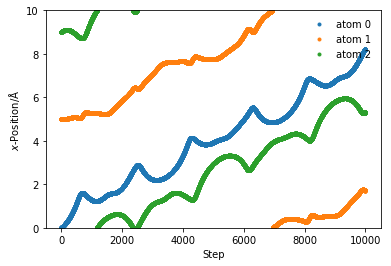

In [17]:
from scipy.constants import Boltzmann

def update_velo(v, a, a1, dt):
    """
    Update the particle velocities.
    
    Parameters
    ----------
    v: ndarray of floats
        The velocities of the particles in a single dimension
    a: ndarray of floats
        The accelerations of the particles in a single dimension 
        at the previous timestep
    a1: ndarray of floats
        The accelerations of the particles in a single dimension
        at the current timestep
    dt: float
        The timestep length
    
    Returns
    -------
    ndarray of floats:
        New velocities of the particles in a single dimension
    """
    return v + 0.5 * (a + a1) * dt

def init_velocity(T, number_of_particles):
    """
    Initialise the velocities for a series of particles.
    
    Parameters
    ----------
    T: float
        Temperature of the system at initialisation
    number_of_particles: int
        Number of particles in the system
    
    Returns
    -------
    ndarray of floats
        Initial velocities for a series of particles
    """
    R = np.random.rand(number_of_particles) - 0.5
    return R * np.sqrt((Boltzmann / 1.602e-19) * T / mass_of_argon)

def run_md(dt, number_of_steps, initial_temp, x, box_length):
    """
    Run a MD simulation.
    
    Parameters
    ----------
    dt: float
        The timestep length
    number_of_steps: int
        Number of iterations in the simulation
    initial_temp: float
        Temperature of the system at initialisation
    x: ndarray of floats
        The initial positions of the particles in a single dimension
        
    Returns
    -------
    ndarray of floats
        The positions for all of the particles throughout the simulation
    """
    cutoff = box_length / 2.
    positions = np.zeros((number_of_steps, x.size))
    v = init_velocity(initial_temp, x.size)
    a = get_accelerations(x, box_length, cutoff)
    for i in range(number_of_steps):
        #print(i)
        x = update_pos(x, v, a, dt, box_length)
        a1 = get_accelerations(x, box_length, cutoff)
        v = update_velo(v, a, a1, dt)
        a = np.array(a1)
        positions[i, :] = x
    return positions

box_length = 10
x = np.array([0, 5, 9])
sim_pos = run_md(1e-1, 10000, 300, x, box_length)
    
%matplotlib inline
for i in range(sim_pos.shape[1]):
    plt.plot(sim_pos[:, i], '.', label='atom {}'.format(i))
plt.ylim(0, box_length)
plt.xlabel(r'Step')
plt.ylabel(r'$x$-Position/Å')
plt.legend(frameon=False)
plt.show()

## References

1. Gumbart, J.; Trabuco, L. G.; Schreiner, E.; Villa, E.; Schulten, K. *Structure* 2009, **17** (11), 1453–1464. [10.1016/j.str.2009.09.010](https://doi.org/10.1016/j.str.2009.09.010).